In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

import esda
from libpysal.weights import Queen
import numpy as np  

import pysal.lib as lib
import pysal.model.spreg as spreg




/opt/conda/lib/python3.11/site-packages/spvcm/utils.py:149: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if np.isinf(ldet) or sgn is 0:
/opt/conda/lib/python3.11/site-packages/spvcm/abstracts.py:268: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if chains is () and kwargs != dict():
/opt/conda/lib/python3.11/site-packages/spvcm/abstracts.py:270: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if chains is not ():
/opt/conda/lib/python3.11/site-packages/spvcm/plotting.py:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if thin is None or thin is 0:


In [2]:
data = pd.read_csv('cleaned_data.csv')

In [3]:
data.head()

,Name,New Code,GCSE_Score,Density,Eng_HH,Lone_Parent,House_Price,Income,Qual_Level4,Out_Work_Fam,Absence,Crime,Bad_Health,Happiness,Green_Space,PTAL,Cars_HH,Deprivation
0,City of London,E09000001,354.500000,2312.500000,3862,153,765000.0,99390.0,68.4,9.500000,0.700000,680.720631,3.4,7.640332,18.629014,7.900000,0.385861,12.124906
1,Abbey,E05000026,317.657759,9884.615385,3397,648,173000.0,38870.0,34.5,22.077922,1.356022,142.212846,4.3,7.897959,21.908601,5.989365,0.547682,32.726127
2,Alibon,E05000027,307.445732,7464.285714,3656,832,215000.0,37290.0,16.7,24.714286,1.489166,75.689606,6.7,7.358842,20.621849,3.145890,0.815160,36.066225
3,Becontree,E05000028,295.451381,8923.076923,3826,880,210000.0,37860.0,20.6,22.023810,1.465376,79.325731,7.0,7.609123,1.885448,2.871767,0.870236,31.686544
4,Chadwell Heath,E05000029,293.437838,2970.588235,3685,776,240500.0,38860.0,19.5,24.333333,1.604042,72.407045,6.8,7.108108,55.974507,2.260909,0.918062,38.044504


## OLS Regression ##

In [4]:
# Define the independent variable matrix X
X = data[['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 'Income', 
          'Qual_Level4', 'Out_Work_Fam', 'Absence', 'Crime', 
          'Bad_Health', 'Happiness', 'Green_Space', 'PTAL', 
          'Cars_HH', 'Deprivation']]

# Add a constant term to the independent variable matrix (required by statsmodels)
X = sm.add_constant(X)

# Calculate VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print(vif)

        Variable          VIF
0          const  1266.344816
1        Density     5.040872
2         Eng_HH     2.511505
3    Lone_Parent     5.637229
4    House_Price     7.929615
5         Income    11.460389
6    Qual_Level4     5.187479
7   Out_Work_Fam     6.676327
8        Absence     2.114778
9          Crime     1.681375
10    Bad_Health     4.221812
11     Happiness     1.139248
12   Green_Space     2.248394
13          PTAL     5.439133
14       Cars_HH    13.085537
15   Deprivation     8.834048


In [5]:
# Define the dependent variable Y and the independent variable matrix X
Y = data['GCSE_Score']
X = data[['Density', 'Eng_HH', 'Lone_Parent', 'House_Price',
          'Qual_Level4', 'Out_Work_Fam', 'Absence', 'Crime', 
          'Bad_Health', 'Happiness', 'Green_Space', 'PTAL', 
           'Deprivation']]

# Add a constant term to the independent variable matrix X
X = sm.add_constant(X)

# Build the OLS regression model
model = sm.OLS(Y, X)

# Fit the model
results = model.fit()

# Output the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             GCSE_Score   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     78.25
Date:                Fri, 23 Aug 2024   Prob (F-statistic):          1.16e-120
Time:                        16:18:38   Log-Likelihood:                -2499.3
No. Observations:                 625   AIC:                             5027.
Df Residuals:                     611   BIC:                             5089.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          336.7818     14.783     22.781   

## RF ##

In [6]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Define the independent variables and the dependent variable
X = data[['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 
          'Income', 'Qual_Level4', 'Out_Work_Fam', 'Absence', 'Crime', 
          'Bad_Health', 'Happiness', 'Green_Space', 'PTAL', 
          'Cars_HH', 'Deprivation']]
y = data['GCSE_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Create a Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)


In [9]:
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Output feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print(feature_importances.sort_values(by='Importance', ascending=False))

Mean Squared Error: 187.38246002983493
         Feature  Importance
6   Out_Work_Fam    0.591702
14   Deprivation    0.052733
4         Income    0.049198
7        Absence    0.049193
5    Qual_Level4    0.042745
3    House_Price    0.029856
0        Density    0.027600
2    Lone_Parent    0.022722
1         Eng_HH    0.022587
11   Green_Space    0.021676
9     Bad_Health    0.019907
8          Crime    0.019079
10     Happiness    0.018900
12          PTAL    0.016319
13       Cars_HH    0.015783


In [10]:
# Calculate R^2
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.5901534246144726


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


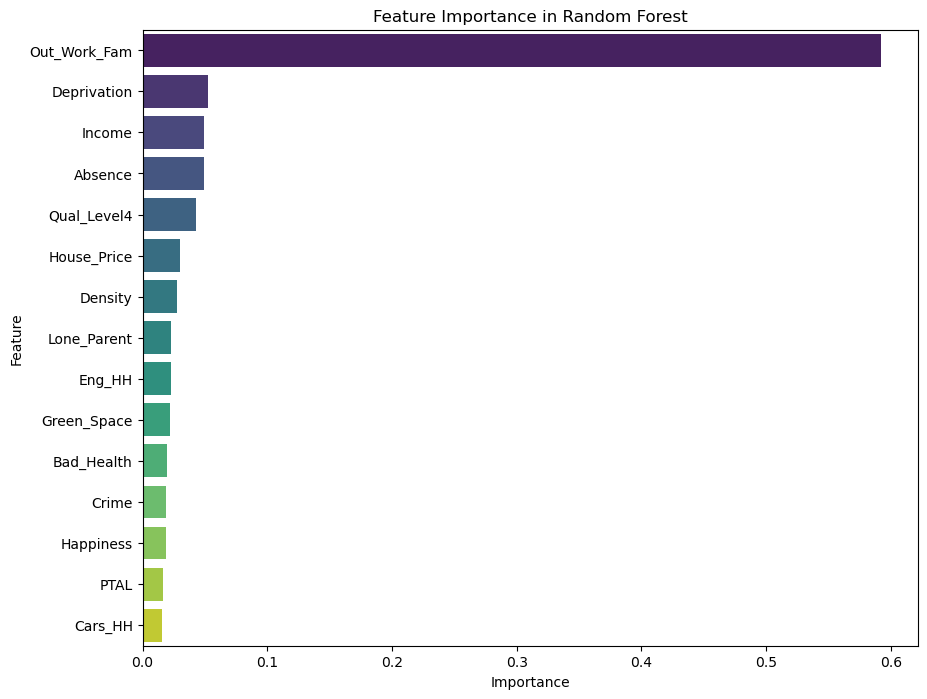

In [11]:
# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance ranking
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

                                  Category  Importance
0                        Family Background    0.663623
1                   Educational Background    0.065332
2         Community and Living Environment    0.129267
3                    Health and Well-being    0.038807
4                     School Participation    0.049193
5  Urban Infrastructure and Transportation    0.053779


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


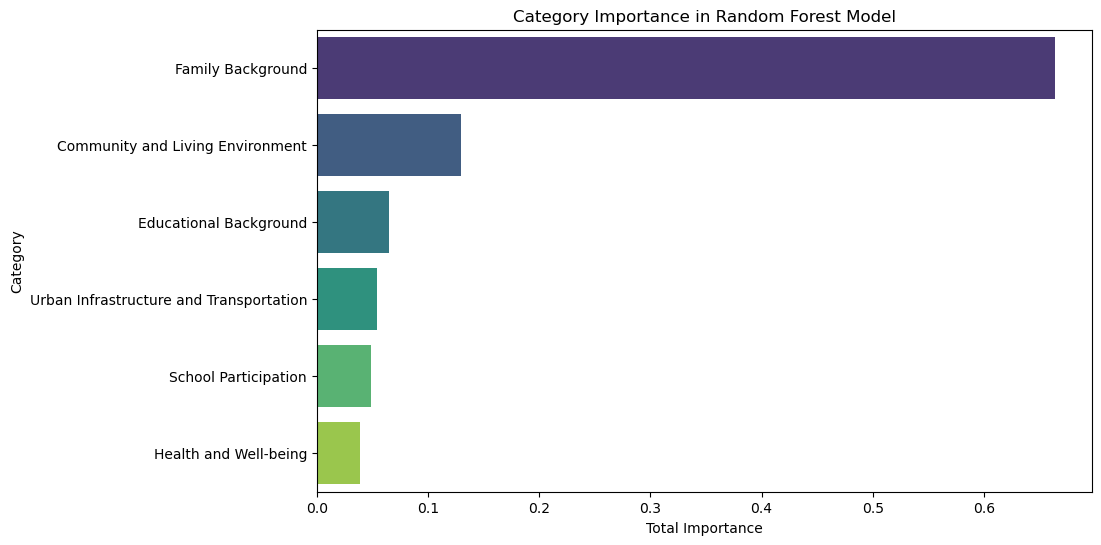

In [12]:
# Extract feature importances from the trained Random Forest model
importances = rf.feature_importances_
feature_names = X.columns

# Define variables for each category
categories = {
    'Family Background': ['Income', 'Lone_Parent', 'Out_Work_Fam'],
    'Educational Background': ['Qual_Level4', 'Eng_HH'],
    'Community and Living Environment': ['House_Price', 'Deprivation', 'Density', 'Crime'],
    'Health and Well-being': ['Bad_Health', 'Happiness'],
    'School Participation': ['Absence'],
    'Urban Infrastructure and Transportation': ['PTAL', 'Green_Space', 'Cars_HH']
}

# Create an empty dictionary to store total importance for each category
category_importance = {}

# Calculate the total importance for each category
for category, vars in categories.items():
    # Sum the importance of all features belonging to this category
    total_importance = sum([importances[feature_names.get_loc(var)] for var in vars if var in feature_names])
    category_importance[category] = total_importance

# Convert the result to a DataFrame for easier viewing
category_importance_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Importance'])

# Output the importance values for each category
print(category_importance_df)

# Sort by importance
category_importance_df = category_importance_df.sort_values(by='Importance', ascending=False)

# Plot the category importance ranking
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Category', data=category_importance_df, palette='viridis')
plt.title('Category Importance in Random Forest Model')
plt.xlabel('Total Importance')
plt.ylabel('Category')
plt.show()

## Spatial Analysis ##

In [13]:
# Read the geographic data and model data
shapefile_path = 'ward/London_Ward.shp'
gdf = gpd.read_file(shapefile_path)
data = pd.read_csv('cleaned_data.csv')

# Define the dependent and independent variables
Y = data['GCSE_Score']
X = data[['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 
          'Qual_Level4', 'Out_Work_Fam', 'Absence', 'Crime', 
          'Bad_Health', 'Happiness', 'Green_Space', 'PTAL', 
          'Deprivation']]

# Add a constant term and fit the model
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()

# Extract residuals
data['residuals'] = results.resid

# Merge residuals with geographic data
merged_gdf = gdf.merge(data, left_on='GSS_CODE', right_on='New Code')

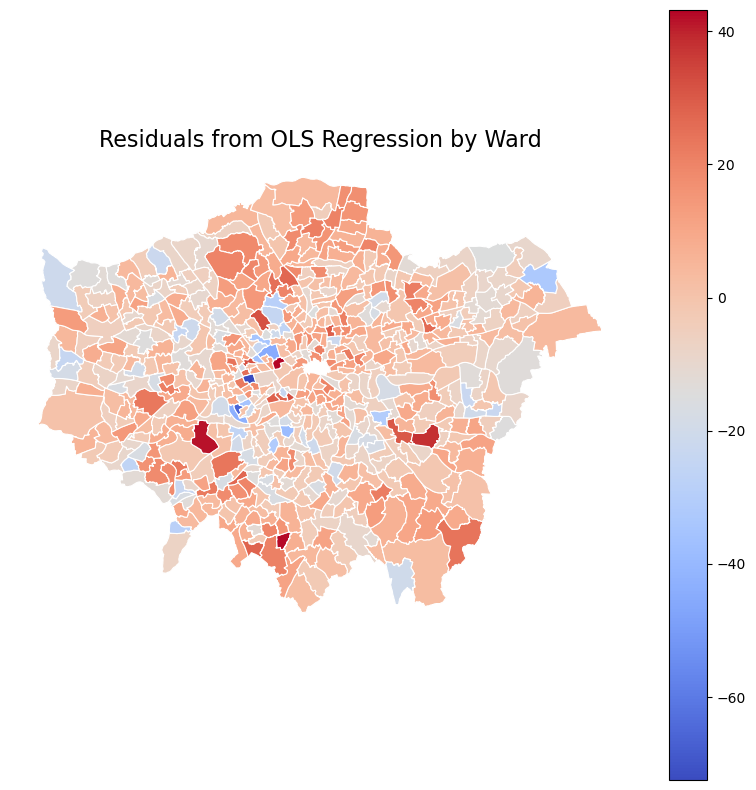

In [14]:
# Plot the distribution of residuals on the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='residuals', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='white', legend=True)

# Add a title
ax.set_title('Residuals from OLS Regression by Ward', fontsize=16)

# Remove the axis
ax.axis('off')
# Display the map
plt.show()

In [15]:
# Read the Shapefile
shapefile_path = 'ward/London_Ward.shp'
gdf = gpd.read_file(shapefile_path)

# Merge geographic data with residuals data
merged_gdf = gdf.merge(data, left_on='GSS_CODE', right_on='New Code')

# Calculate the adjacency weight matrix
w = Queen.from_dataframe(merged_gdf)

# Compute Moran's I index
moran = esda.Moran(merged_gdf['residuals'], w)

# Output the Moran's I results
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

/tmp/ipykernel_959/3607955626.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_gdf)


Moran's I: 0.1763563472218113
p-value: 0.001


In [16]:
pip install pysal


Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install --upgrade pysal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.3/347.3 kB 9.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.0/357.0 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: mapclassify
    Found existing installation: mapclassify 2.6.1
    Uninstalling mapclassify-2.6.1:
      Successfully uninstalled mapclassify-2.6.1
  Attempting uninst

In [18]:
# Read the geographic data and model data
shapefile_path = 'ward/London_ward.shp'
gdf = gpd.read_file(shapefile_path)
data = pd.read_csv('cleaned_data.csv')

# Ensure alignment of geographic data and regression data
gdf = gdf.sort_values(by='GSS_CODE')  # Assuming the geographic data has a unique identifier 'GSS_CODE'
data = data.sort_values(by='New Code')  # Assuming the economic data has a matching unique identifier 'New Code'

# Merge data to ensure geographic and regression data are completely aligned
merged_gdf = gdf.merge(data, left_on='GSS_CODE', right_on='New Code')

# Define the dependent and independent variables
y = merged_gdf['GCSE_Score'].values
X = merged_gdf[['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 
                 'Qual_Level4', 'Out_Work_Fam', 'Absence', 
                'Crime', 'Bad_Health', 'Happiness', 'Green_Space', 
                'PTAL',  'Deprivation']].values

# Construct the spatial weight matrix
w = lib.weights.Queen.from_dataframe(merged_gdf)  # Using Queen contiguity spatial weights
w.transform = 'r'  # Standardize the weight matrix

# Estimate the Spatial Lag Model (SAR)
model = spreg.ML_Lag(y, X, w=w, name_y='GCSE_Score', name_x=['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 
                                                             'Qual_Level4', 'Out_Work_Fam', 'Absence', 
                                                            'Crime', 'Bad_Health', 'Happiness', 'Green_Space', 
                                                            'PTAL',  'Deprivation'])

# Output the results
print(model.summary)

/tmp/ipykernel_959/1992066794.py:21: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lib.weights.Queen.from_dataframe(merged_gdf)  # Using Queen contiguity spatial weights


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  GCSE_Score                Number of Observations:         624
Mean dependent var  :    327.2229                Number of Variables   :          15
S.D. dependent var  :     21.5491                Degrees of Freedom    :         609
Pseudo R-squared    :      0.6425
Spatial Pseudo R-squared:  0.6152
Log likelihood      :  -2482.9795
Sigma-square ML     :    165.7628                Akaike info criterion :    4995.959
S.E of regression   :     12.8749                Schwarz criterion     :    5062.501

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [19]:
# Read the geographic data and model data
shapefile_path = 'ward/London_ward.shp'
gdf = gpd.read_file(shapefile_path)
data = pd.read_csv('cleaned_data.csv')

# Ensure alignment of geographic data and regression data
gdf = gdf.sort_values(by='GSS_CODE')  # Assuming the geographic data has a unique identifier 'GSS_CODE'
data = data.sort_values(by='New Code')  # Assuming the economic data has a matching unique identifier 'New Code'

# Merge the data to ensure that geographic and regression data are fully aligned
merged_gdf = gdf.merge(data, left_on='GSS_CODE', right_on='New Code')

# Define the dependent and independent variables
y = merged_gdf['GCSE_Score'].values
X = merged_gdf[['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 
                 'Qual_Level4', 'Out_Work_Fam', 'Absence', 
                'Crime', 'Bad_Health', 'Happiness', 'Green_Space', 
                'PTAL',  'Deprivation']].values

# Construct the spatial weight matrix (using the merged data)
w = lib.weights.Queen.from_dataframe(merged_gdf)  # Using Queen contiguity spatial weights
w.transform = 'r'  # Standardize the weight matrix

# Estimate the Spatial Error Model (SEM)
model = spreg.ML_Error(y, X, w=w, name_y='GCSE_Score', name_x=['Density', 'Eng_HH', 'Lone_Parent', 'House_Price', 
                                                               'Qual_Level4', 'Out_Work_Fam', 'Absence', 
                                                              'Crime', 'Bad_Health', 'Happiness', 'Green_Space', 
                                                              'PTAL',  'Deprivation'])

# Output the results
print(model.summary)

/tmp/ipykernel_959/252869347.py:21: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lib.weights.Queen.from_dataframe(merged_gdf)  # Using Queen contiguity spatial weights
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  GCSE_Score                Number of Observations:         624
Mean dependent var  :    327.2229                Number of Variables   :          14
S.D. dependent var  :     21.5491                Degrees of Freedom    :         610
Pseudo R-squared    :      0.6222
Log likelihood      :  -2473.2014
Sigma-square ML     :    157.7431                Akaike info criterion :    4974.403
S.E of regression   :     12.5596                Schwarz criterion     :    5036.509

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       331.60503    

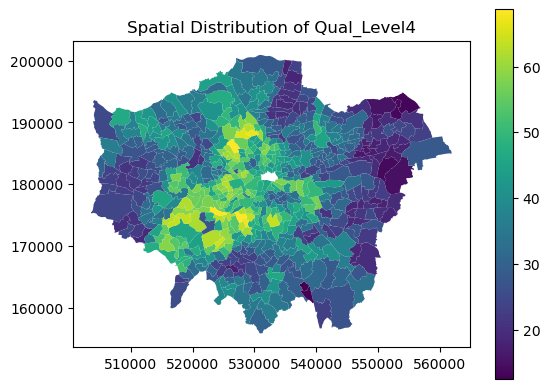

In [20]:
# Plot the spatial distribution of the significant variable
merged_gdf.plot(column='Qual_Level4', cmap='viridis', legend=True)
plt.title('Spatial Distribution of Qual_Level4')
plt.show()